In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from scipy.stats import probplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
ss = StandardScaler()
mm = MinMaxScaler()

# 33년간의 사기범죄건수 데이터와 다른 항목간의 추세 알아보기

In [2]:
df_crime = pd.read_csv("./data_사기/crime_1990_2001.csv", encoding = "cp949")
df_crime2 = pd.read_csv("./data_사기/crime_2002_2013.csv", encoding = "cp949")
df_crime3 = pd.read_csv("./data_사기/crime_2014_2022.csv", encoding = "cp949")
df_crime = pd.concat([df_crime.iloc[:,2:4], df_crime2.iloc[:, 2:4], df_crime3.iloc[:, 2:4]], axis = 0).reset_index(drop=True)
df_crime.columns = ["년도" , "사기건수"] # 33년간의 사기범죄건수 데이터
df_gdp = pd.read_csv("./data_사기/GDP_1990_2022.csv").iloc[:, 1:] # 33년간 gdp의 변화
df_worker = pd.read_csv("./data_사기/worker_1990_2022.csv").iloc[:, 1:] # 33년간의 취업자 수 변화
df_data = pd.read_csv("./data_사기/data_1990_2022.csv").iloc[:, 1:] # 33년간의 출생아 수, 사망자 수, 혼인 건 수, 이혼 건 수
df = pd.concat([df_crime, df_gdp, df_worker, df_data], axis = 1).drop("시점", axis = 1)
df.columns = ["year", "crime", "gdp", "worker", "born", "dead", "marry", "divorce"]

In [3]:
df.head()

,year,crime,gdp,worker,born,dead,marry,divorce
0,1990,43209,4794,18085,649738,241616,399312,45694
1,1991,51100,5757,18649,709275,242270,416872,49205
2,1992,72640,6519,19009,730678,236162,419774,53539
3,1993,97854,7299,19234,715826,234257,402593,59313
4,1994,132537,8522,19848,721185,242439,393121,65015


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   year     33 non-null     int64
 1   crime    33 non-null     int64
 2   gdp      33 non-null     int64
 3   worker   33 non-null     int64
 4   born     33 non-null     int64
 5   dead     33 non-null     int64
 6   marry    33 non-null     int64
 7   divorce  33 non-null     int64
dtypes: int64(8)
memory usage: 2.2 KB


- 모든 데이터가 수치형이라 분석하기에 알맞음

In [5]:
df.describe()

,year,crime,gdp,worker,born,dead,marry,divorce
count,33.00000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,2006.00000,209687.030303,21935.757576,23173.787879,507559.212121,261425.454545,325283.515152,105673.424242
std,9.66954,72737.468903,11275.599560,2898.527069,145695.649454,29386.038662,62972.106614,28257.462461
min,1990.00000,43209.000000,4794.000000,18085.000000,249186.000000,234257.000000,191690.000000,45694.000000
25%,1998.00000,182052.000000,11863.000000,20853.000000,436455.000000,244162.000000,302828.000000,93232.000000
50%,2006.00000,205913.000000,20878.000000,23188.000000,476958.000000,246942.000000,326104.000000,114284.000000
75%,2014.00000,246204.000000,30861.000000,25897.000000,641594.000000,267692.000000,373500.000000,119455.000000
max,2022.00000,354154.000000,41948.000000,28089.000000,730678.000000,372939.000000,434911.000000,166617.000000


- 비교적 차이가 있어 스케일링을 진행하면 좋아보임

# OLS 검정(선형회귀)을 통한 유의미 할 수 있는 항목들 찾기

In [6]:
ss = StandardScaler()

In [7]:
x = df[['gdp', 'worker', 'born', 'dead', 'marry', 'divorce']]
y = df["crime"]
x = pd.DataFrame(ss.fit_transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     29.85
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           1.78e-10
Time:                        17:17:28   Log-Likelihood:                -381.66
No. Observations:                  33   AIC:                             777.3
Df Residuals:                      26   BIC:                             787.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.097e+05   5001.221     41.927      0.000    1.99e+05     2.2e+05
gdp        -1.033e+04   5.65e+04     -0.183      0.856   -1.26e+05    1.06e+05
worker      5.263e+04   4.89e+04      1.076      0.292   -4.79e+04    1.53e+05
born        9867.9623    2.5e+04      0.394      0.697   -4.16e+04    6.13e+04
dead        3.306e+04   1.48e+04      2.230      0.035    2589.649    6.35e+04
marry       9784.9827   2.27e+04      0.431      0.670   -3.69e+04    5.64e+04
divorce     3.042e+04   9166.764      3.318      0.003    1.16e+04    4.93e+04
==============================================================================
Omnibus:                        5.099   Durbin-Watson:                   1.112
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                3.945
Skew:                           0.836   Prob(JB):                        0.139
Kurtosis:                       3.270   Cond. No.                         32.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- p-value가 높은 항목부터 하나씩 제거

In [8]:
x = df[['worker', 'born', 'dead', 'marry', 'divorce']]
y = df["crime"]
x = pd.DataFrame(ss.fit_transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     37.15
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           2.79e-11
Time:                        17:17:28   Log-Likelihood:                -381.68
No. Observations:                  33   AIC:                             775.4
Df Residuals:                      27   BIC:                             784.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.097e+05   4910.887     42.698      0.000       2e+05     2.2e+05
worker      4.418e+04   1.58e+04      2.799      0.009    1.18e+04    7.66e+04
born        1.151e+04   2.29e+04      0.502      0.620   -3.56e+04    5.86e+04
dead        3.266e+04   1.44e+04      2.269      0.031    3122.554    6.22e+04
marry       9953.8512   2.23e+04      0.447      0.658   -3.57e+04    5.57e+04
divorce      3.09e+04   8623.975      3.583      0.001    1.32e+04    4.86e+04
==============================================================================
Omnibus:                        5.226   Durbin-Watson:                   1.099
Prob(Omnibus):                  0.073   Jarque-Bera (JB):                4.052
Skew:                           0.846   Prob(JB):                        0.132
Kurtosis:                       3.287   Cond. No.                         12.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
x = df[['worker', 'born', 'dead', 'divorce']]
y = df["crime"]
x = pd.DataFrame(ss.fit_transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     47.75
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           4.12e-12
Time:                        17:17:28   Log-Likelihood:                -381.80
No. Observations:                  33   AIC:                             773.6
Df Residuals:                      28   BIC:                             781.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.097e+05   4840.199     43.322      0.000       2e+05     2.2e+05
worker      4.636e+04   1.48e+04      3.133      0.004    1.61e+04    7.67e+04
born        1.855e+04   1.65e+04      1.128      0.269   -1.52e+04    5.23e+04
dead        2.827e+04   1.04e+04      2.726      0.011    7023.810    4.95e+04
divorce     2.881e+04   7143.690      4.033      0.000    1.42e+04    4.34e+04
==============================================================================
Omnibus:                        4.804   Durbin-Watson:                   1.131
Prob(Omnibus):                  0.091   Jarque-Bera (JB):                3.796
Skew:                           0.827   Prob(JB):                        0.150
Kurtosis:                       3.158   Cond. No.                         7.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
x = df[['worker', 'dead', 'divorce']]
y = df["crime"]
x = pd.DataFrame(ss.fit_transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     62.65
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           8.76e-13
Time:                        17:17:28   Log-Likelihood:                -382.53
No. Observations:                  33   AIC:                             773.1
Df Residuals:                      29   BIC:                             779.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.097e+05   4862.784     43.121      0.000       2e+05     2.2e+05
worker      3.449e+04   1.04e+04      3.303      0.003    1.31e+04    5.58e+04
dead        2.341e+04   9479.321      2.470      0.020    4025.781    4.28e+04
divorce     2.487e+04   6260.219      3.973      0.000    1.21e+04    3.77e+04
==============================================================================
Omnibus:                        3.742   Durbin-Watson:                   0.950
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                3.193
Skew:                           0.757   Prob(JB):                        0.203
Kurtosis:                       2.825   Cond. No.                         4.05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
x.columns

Index(['worker', 'dead', 'divorce'], dtype='object')

- 각 항목이 p-value가 0.05 미만으로 만족하는 것으로 보아 "취업자 수", "사망자 수", "이혼 건 수" 가 영향이 있는 항목임을 알 수 있음

In [12]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(new_x.values, i) for i in range(new_x.shape[1])]
vif["feature"] = new_x.columns
vif.round(1)

,VIF_Factor,feature
0,1.0,const
1,4.6,worker
2,3.8,dead
3,1.7,divorce


In [13]:
use_df = df.drop(["year", "gdp", "marry", "born"], axis = 1)
scaled_df = pd.DataFrame(ss.fit_transform(use_df), columns = use_df.columns)

<function matplotlib.pyplot.show(close=None, block=None)>

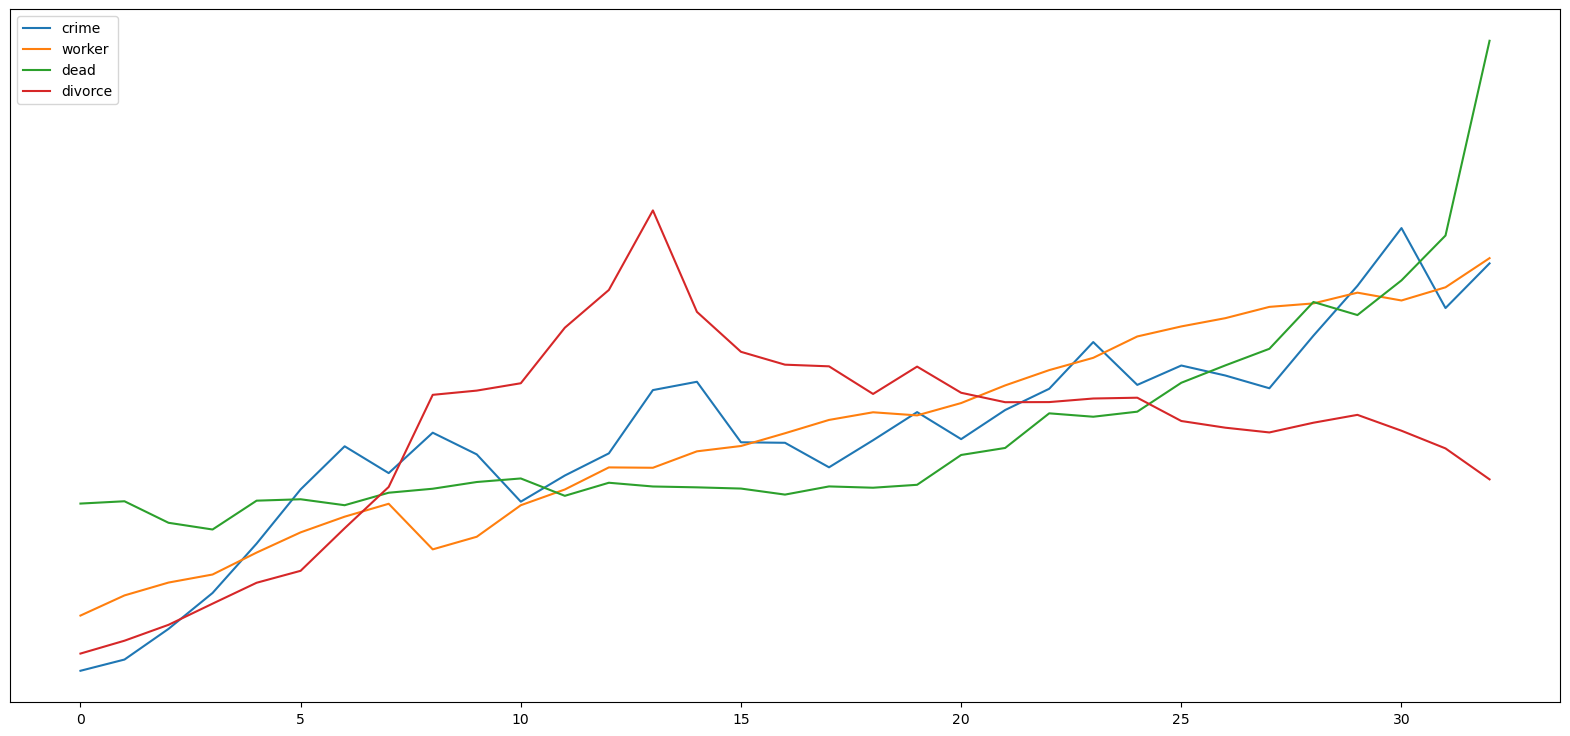

In [14]:
plt.figure(figsize = (20, 9))

for i in scaled_df:
    plt.plot(scaled_df.index, scaled_df[i], label = i)
plt.plot
plt.gca().axes.yaxis.set_visible(False)
plt.legend()
plt.show

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


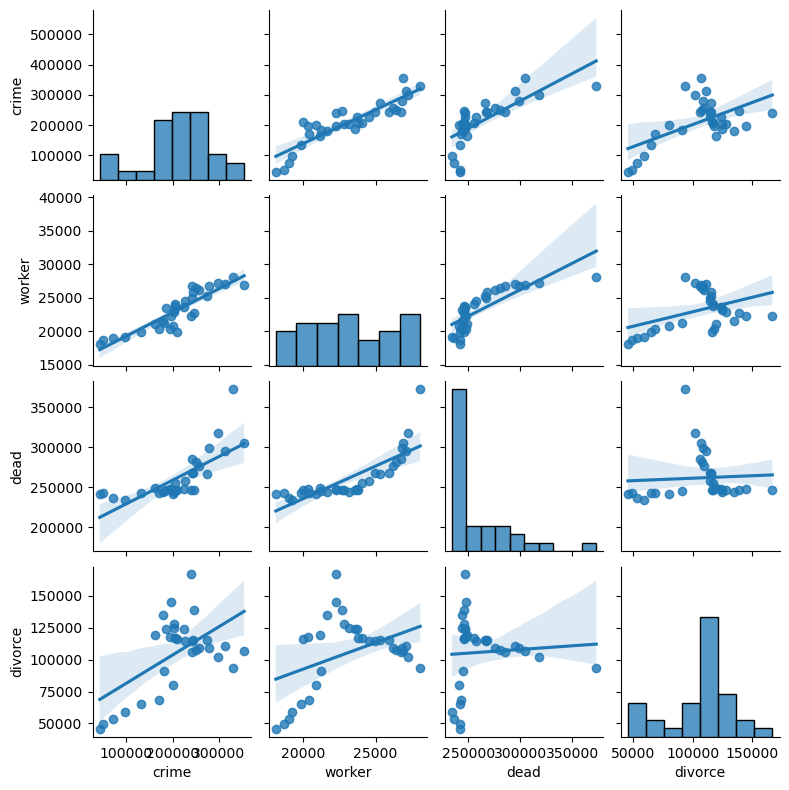

In [15]:
sns.pairplot(use_df, kind='reg', height=2)

# 지역 데이터로 검증해보기

In [16]:
df_c_divorce = pd.read_csv("./data_사기/city_divorce.csv")
df_c_worker = pd.read_csv("./data_사기/city_worker.csv")
df_c_dead = pd.read_csv("./data_사기/city_dead.csv")
df_c_dead = df_c_dead[["시도별", "시점", "계"]]
df_c_dead = df_c_dead.loc[df_c_dead["계"] != "-"]
df_c_dead["계"] = df_c_dead["계"].astype(int)

In [17]:
pd.set_option("display.max_rows", None)

In [18]:
df.loc[8:]

,year,crime,gdp,worker,born,dead,marry,divorce
8,1998,210436,11691,19938,641594,245825,373500,116294
9,1999,195197,12757,20291,620668,247734,360407,117449
10,2000,161986,13952,21173,640089,248740,332090,119455
11,2001,180350,15009,21614,559934,243813,318407,134608
12,2002,195914,16505,22232,496911,247524,304877,144910
13,2003,240359,17609,22222,495036,246463,302503,166617
14,2004,246204,19027,22682,476958,246220,308598,138932
15,2005,203697,19902,22831,438707,245874,314304,128035
16,2006,203346,20878,23188,451759,244162,330634,124524
17,2007,186115,22456,23561,496822,246482,343559,124072


In [19]:
# "지역명", "시점", "이혼건수(건)", "취업자 수(천 명)", "사망자 수(명)", "전국범죄건수"
서울특별시 = pd.concat([df_c_divorce[df_c_divorce["행정구역별(1)"] == "서울특별시"].reset_index(drop =True),
                   df_c_worker[df_c_worker["시도별"] == "서울특별시"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                  df_c_dead[df_c_dead["시도별"] == "서울특별시"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                  df["crime"]], axis = 1)
서울특별시.columns = ["city_name", "year", "divorce", "worker", "dead", "crime"]

부산광역시 = pd.concat([df_c_divorce[df_c_divorce["행정구역별(1)"] == "부산광역시"].reset_index(drop =True),
                   df_c_worker[df_c_worker["시도별"] == "부산광역시"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                  df_c_dead[df_c_dead["시도별"] == "부산광역시"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                  df["crime"]], axis = 1)
부산광역시.columns = ["city_name", "year", "divorce", "worker", "dead", "crime"]

대구광역시 = pd.concat([df_c_divorce[df_c_divorce["행정구역별(1)"] == "대구광역시"].reset_index(drop =True), 
                   df_c_worker[df_c_worker["시도별"] == "대구광역시"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                  df_c_dead[df_c_dead["시도별"] == "대구광역시"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                  df["crime"]], axis = 1)
대구광역시.columns = ["city_name", "year", "divorce", "worker", "dead", "crime"]

인천광역시 = pd.concat([df_c_divorce[df_c_divorce["행정구역별(1)"] == "인천광역시"].reset_index(drop =True),
                   df_c_worker[df_c_worker["시도별"] == "인천광역시"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                  df_c_dead[df_c_dead["시도별"] == "인천광역시"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                  df["crime"]], axis = 1)
인천광역시.columns = ["city_name", "year", "divorce", "worker", "dead", "crime"]

광주광역시 = pd.concat([df_c_divorce[df_c_divorce["행정구역별(1)"] == "광주광역시"].reset_index(drop =True),
                   df_c_worker[df_c_worker["시도별"] == "광주광역시"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                  df_c_dead[df_c_dead["시도별"] == "광주광역시"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                  df["crime"]], axis = 1)
광주광역시.columns = ["city_name", "year", "divorce", "worker", "dead", "crime"]

대전광역시 = pd.concat([df_c_divorce[df_c_divorce["행정구역별(1)"] == "대전광역시"].reset_index(drop =True)
                   , df_c_worker[df_c_worker["시도별"] == "대전광역시"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                  df_c_dead[df_c_dead["시도별"] == "대전광역시"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                  df["crime"]], axis = 1)
대전광역시.columns = ["city_name", "year", "divorce", "worker", "dead", "crime"]

경기도 = pd.concat([df_c_divorce[df_c_divorce["행정구역별(1)"] == "경기도"].reset_index(drop =True)
                 , df_c_worker[df_c_worker["시도별"] == "경기도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                df_c_dead[df_c_dead["시도별"] == "경기도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                df["crime"]], axis = 1)
경기도.columns = ["city_name", "year", "divorce", "worker", "dead", "crime"]

강원도 = pd.concat([df_c_divorce[df_c_divorce["행정구역별(1)"] == "강원특별자치도"].reset_index(drop =True),
                 df_c_worker[df_c_worker["시도별"] == "강원도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                df_c_dead[df_c_dead["시도별"] == "강원도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                df["crime"]], axis = 1)
강원도.columns = ["city_name", "year", "divorce", "worker", "dead", "crime"]

충청북도 = pd.concat([df_c_divorce[df_c_divorce["행정구역별(1)"] == "충청북도"].reset_index(drop =True),
                  df_c_worker[df_c_worker["시도별"] == "충청북도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                 df_c_dead[df_c_dead["시도별"] == "충청북도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                 df["crime"]], axis = 1)
충청북도.columns = ["city_name", "year", "divorce", "worker", "dead", "crime"]

충청남도 = pd.concat([df_c_divorce[df_c_divorce["행정구역별(1)"] == "충청남도"].reset_index(drop =True),
                  df_c_worker[df_c_worker["시도별"] == "충청남도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                 df_c_dead[df_c_dead["시도별"] == "충청남도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                 df["crime"]], axis = 1)
충청남도.columns = ["city_name", "year", "divorce", "worker", "dead", "crime"]

전라북도 = pd.concat([df_c_divorce[df_c_divorce["행정구역별(1)"] == "전라북도"].reset_index(drop =True),
                  df_c_worker[df_c_worker["시도별"] == "전라북도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                 df_c_dead[df_c_dead["시도별"] == "전라북도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                 df["crime"]], axis = 1)
전라북도.columns = ["city_name", "year", "divorce", "worker", "dead", "crime"]

전라남도 = pd.concat([df_c_divorce[df_c_divorce["행정구역별(1)"] == "전라남도"].reset_index(drop =True),
                  df_c_worker[df_c_worker["시도별"] == "전라남도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                 df_c_dead[df_c_dead["시도별"] == "전라남도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                 df["crime"]], axis = 1)
전라남도.columns = ["city_name", "year", "divorce", "worker", "dead", "crime"]

경상북도 = pd.concat([df_c_divorce[df_c_divorce["행정구역별(1)"] == "경상북도"].reset_index(drop =True),
                  df_c_worker[df_c_worker["시도별"] == "경상북도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                 df_c_dead[df_c_dead["시도별"] == "경상북도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                 df["crime"]], axis = 1)
경상북도.columns = ["city_name", "year", "divorce", "worker", "dead", "crime"]

경상남도 = pd.concat([df_c_divorce[df_c_divorce["행정구역별(1)"] == "경상남도"].reset_index(drop =True),
                  df_c_worker[df_c_worker["시도별"] == "경상남도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                 df_c_dead[df_c_dead["시도별"] == "경상남도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                 df["crime"]], axis = 1)
경상남도.columns = ["city_name", "year", "divorce", "worker", "dead", "crime"]

제주특별자치도 = pd.concat([df_c_divorce[df_c_divorce["행정구역별(1)"] == "제주특별자치도"].reset_index(drop =True),
                     df_c_worker[df_c_worker["시도별"] == "제주도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                    df_c_dead[df_c_dead["시도별"] == "제주도"].drop(["시도별", "시점"], axis = 1).reset_index(drop =True),
                    df["crime"]], axis = 1)
제주특별자치도.columns = ["city_name", "year", "divorce", "worker", "dead", "crime"]

In [20]:
울산광역시 = pd.concat([df_c_divorce[df_c_divorce["행정구역별(1)"] == "울산광역시"].iloc[1:].reset_index(drop = True),
                df_c_worker[df_c_worker["시도별"] == "울산광역시"].reset_index(drop = True).drop(["시도별", "시점"], axis = 1),
                df_c_dead[df_c_dead["시도별"] == "울산광역시"][1:].reset_index(drop = True).drop(["시도별", "시점"], axis = 1),
                  df.loc[8:]["crime"].reset_index(drop = True)], axis = 1).reset_index(drop = True)
울산광역시.columns = ["city_name", "year", "divorce", "worker", "dead", "crime"]

서울특별시.to_csv('서울특별시.csv', index=False)
부산광역시.to_csv('부산광역시.csv', index=False)
대구광역시.to_csv('대구광역시.csv', index=False)
인천광역시.to_csv('인천광역시.csv', index=False)
광주광역시.to_csv('광주광역시.csv', index=False)
대전광역시.to_csv('대전광역시.csv', index=False)
울산광역시.to_csv('울산광역시.csv', index=False)
경기도.to_csv('경기도.csv', index=False)
강원도.to_csv('강원도.csv', index=False)
충청북도.to_csv('충청북도.csv', index=False)
충청남도.to_csv('충청남도.csv', index=False)
전라북도.to_csv('전라북도.csv', index=False)
전라남도.to_csv('전라남도.csv', index=False)
경상북도.to_csv('경상북도.csv', index=False)
경상남도.to_csv('경상남도.csv', index=False)
제주특별자치도.to_csv('제주특별자치도.csv', index=False)

In [21]:
city = ['서울특별시', '부산광역시', '대구광역시', '인천광역시', '광주광역시', '대전광역시', '울산광역시', '세종특별자치시', '경기도', '강원도', '충청북도', '충청남도', '전라북도', '전라남도', '경상북도', '경상남도', '제주특별자치도']

In [22]:
table = pd.concat([서울특별시, 부산광역시, 대구광역시, 인천광역시, 광주광역시, 대전광역시, 울산광역시, 경기도, 강원도, 충청북도, 충청남도, 전라북도, 전라남도, 경상북도, 경상남도, 제주특별자치도], axis = 0)

In [23]:
x = df[['worker', 'dead', 'divorce']]
ss.fit(x)

StandardScaler()

In [43]:
x = 서울특별시[['worker', 'dead', 'divorce']]
y = df["crime"]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     38.59
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           2.98e-10
Time:                        17:19:27   Log-Likelihood:                -389.21
No. Observations:                  33   AIC:                             786.4
Df Residuals:                      29   BIC:                             792.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.83e+06   5.33e+05     10.934      0.000    4.74e+06    6.92e+06
worker      3.337e+05   8.99e+04      3.711      0.001     1.5e+05    5.18e+05
dead        3.861e+05   6.32e+04      6.108      0.000    2.57e+05    5.15e+05
divorce     1.766e+05   3.65e+04      4.832      0.000    1.02e+05    2.51e+05
==============================================================================
Omnibus:                        5.343   Durbin-Watson:                   1.053
Prob(Omnibus):                  0.069   Jarque-Bera (JB):                3.899
Skew:                           0.799   Prob(JB):                        0.142
Kurtosis:                       3.533   Cond. No.                         942.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 대한민국 인구의 많은 비율을 차지하고 있는 서울특별시의 경우 P-value로 보아 유의미 하나 Cond.No를 보아 다중공선성이 의심이 됩니다.

In [44]:
x = 부산광역시[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     42.53
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           9.64e-11
Time:                        17:19:31   Log-Likelihood:                -387.92
No. Observations:                  33   AIC:                             783.8
Df Residuals:                      29   BIC:                             789.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.24e+07   2.88e+06      4.311      0.000    6.52e+06    1.83e+07
worker       6.59e+05   3.88e+05      1.697      0.100   -1.35e+05    1.45e+06
dead        7.442e+05   7.25e+04     10.264      0.000    5.96e+05    8.92e+05
divorce     2.837e+05   7.84e+04      3.620      0.001    1.23e+05    4.44e+05
==============================================================================
Omnibus:                        0.737   Durbin-Watson:                   1.157
Prob(Omnibus):                  0.692   Jarque-Bera (JB):                0.278
Skew:                          -0.220   Prob(JB):                        0.870
Kurtosis:                       3.091   Cond. No.                     6.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
x = 부산광역시[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x.drop("worker", axis = 1))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     58.67
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           4.29e-11
Time:                        17:19:33   Log-Likelihood:                -389.48
No. Observations:                  33   AIC:                             785.0
Df Residuals:                      30   BIC:                             789.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.661e+06   7.13e+05     10.749      0.000    6.21e+06    9.12e+06
dead        7.756e+05   7.23e+04     10.731      0.000    6.28e+05    9.23e+05
divorce     2.748e+05   8.06e+04      3.409      0.002     1.1e+05    4.39e+05
==============================================================================
Omnibus:                        0.813   Durbin-Watson:                   0.868
Prob(Omnibus):                  0.666   Jarque-Bera (JB):                0.361
Skew:                          -0.254   Prob(JB):                        0.835
Kurtosis:                       3.067   Cond. No.                     1.11e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- 부산광역시의 경우 취업자 수는 영향을 끼치지 않는 것으로 예상됩니다.

In [27]:
x = 대구광역시[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     73.34
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           1.20e-13
Time:                        17:17:32   Log-Likelihood:                -380.26
No. Observations:                  33   AIC:                             768.5
Df Residuals:                      29   BIC:                             774.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.32e+07   1.11e+06     11.841      0.000    1.09e+07    1.55e+07
worker      7.163e+05   2.61e+05      2.748      0.010    1.83e+05    1.25e+06
dead        7.514e+05   1.38e+05      5.429      0.000    4.68e+05    1.03e+06
divorce      2.71e+05   1.11e+05      2.441      0.021    4.39e+04    4.98e+05
==============================================================================
Omnibus:                        5.108   Durbin-Watson:                   1.173
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                3.644
Skew:                           0.764   Prob(JB):                        0.162
Kurtosis:                       3.562   Cond. No.                     3.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- 대구광역시의 경우 모든 P-value를 만족하지만 Cond를 보아 다중공선성이 의심됩니다.

In [28]:
x = 인천광역시[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     81.20
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           3.24e-14
Time:                        17:17:32   Log-Likelihood:                -378.77
No. Observations:                  33   AIC:                             765.5
Df Residuals:                      29   BIC:                             771.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.536e+06   4.09e+05     15.989      0.000     5.7e+06    7.37e+06
worker      1.596e+05   1.76e+05      0.909      0.371   -1.99e+05    5.19e+05
dead        4.943e+05   1.55e+05      3.195      0.003    1.78e+05    8.11e+05
divorce     2.352e+05   6.36e+04      3.696      0.001    1.05e+05    3.65e+05
==============================================================================
Omnibus:                        3.485   Durbin-Watson:                   1.157
Prob(Omnibus):                  0.175   Jarque-Bera (JB):                2.992
Skew:                           0.730   Prob(JB):                        0.224
Kurtosis:                       2.785   Cond. No.                     1.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
x = 인천광역시[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x.drop("worker", axis = 1))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     122.1
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           3.85e-15
Time:                        17:22:28   Log-Likelihood:                -379.23
No. Observations:                  33   AIC:                             764.5
Df Residuals:                      30   BIC:                             769.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.504e+06   4.06e+05     16.018      0.000    5.67e+06    7.33e+06
dead        6.272e+05   5.04e+04     12.438      0.000    5.24e+05     7.3e+05
divorce     2.481e+05   6.18e+04      4.013      0.000    1.22e+05    3.74e+05
==============================================================================
Omnibus:                        2.404   Durbin-Watson:                   1.140
Prob(Omnibus):                  0.301   Jarque-Bera (JB):                2.080
Skew:                           0.597   Prob(JB):                        0.353
Kurtosis:                       2.701   Cond. No.                         886.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 인천광역시의 경우 취업자 수가 영향을 끼치지 않을 것으로 예상되며 역시 사망자 수와 이혼 건 수 사이의 다중 공선성이 의심되는 상황입니다.

In [29]:
x = 광주광역시[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     63.78
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           7.00e-13
Time:                        17:17:33   Log-Likelihood:                -382.28
No. Observations:                  33   AIC:                             772.6
Df Residuals:                      29   BIC:                             778.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.807e+07   1.49e+06     12.103      0.000     1.5e+07    2.11e+07
worker      4.787e+05   3.75e+05      1.276      0.212   -2.89e+05    1.25e+06
dead        1.197e+06   3.59e+05      3.334      0.002    4.63e+05    1.93e+06
divorce     9.514e+05    2.6e+05      3.664      0.001     4.2e+05    1.48e+06
==============================================================================
Omnibus:                        3.654   Durbin-Watson:                   0.989
Prob(Omnibus):                  0.161   Jarque-Bera (JB):                2.963
Skew:                           0.733   Prob(JB):                        0.227
Kurtosis:                       2.939   Cond. No.                     3.94e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
x = 광주광역시[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x.drop("worker", axis = 1))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     92.92
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           1.40e-13
Time:                        17:23:26   Log-Likelihood:                -383.18
No. Observations:                  33   AIC:                             772.4
Df Residuals:                      30   BIC:                             776.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.881e+07   1.39e+06     13.566      0.000     1.6e+07    2.16e+07
dead        1.613e+06   1.53e+05     10.555      0.000     1.3e+06    1.93e+06
divorce     1.186e+06   1.85e+05      6.402      0.000    8.08e+05    1.56e+06
==============================================================================
Omnibus:                        2.801   Durbin-Watson:                   1.005
Prob(Omnibus):                  0.246   Jarque-Bera (JB):                2.158
Skew:                           0.626   Prob(JB):                        0.340
Kurtosis:                       2.949   Cond. No.                     2.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- 광주광역시 역시 취업자 수가 영향을 미치지 않을 것으로 예상되며 사망자 수와 이혼 건 수 사이의 다중공선성이 의심됩니다.

In [30]:
x = 대전광역시[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     70.14
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           2.11e-13
Time:                        17:17:33   Log-Likelihood:                -380.91
No. Observations:                  33   AIC:                             769.8
Df Residuals:                      29   BIC:                             775.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.662e+07   1.37e+06     12.086      0.000    1.38e+07    1.94e+07
worker      6.069e+05    3.1e+05      1.958      0.060   -2.69e+04    1.24e+06
dead         1.09e+06   3.28e+05      3.322      0.002    4.19e+05    1.76e+06
divorce     5.408e+05   1.94e+05      2.785      0.009    1.44e+05    9.38e+05
==============================================================================
Omnibus:                        3.377   Durbin-Watson:                   0.961
Prob(Omnibus):                  0.185   Jarque-Bera (JB):                2.938
Skew:                           0.719   Prob(JB):                        0.230
Kurtosis:                       2.739   Cond. No.                     3.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
x = 대전광역시[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x.drop("worker", axis = 1))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     94.38
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           1.14e-13
Time:                        17:24:28   Log-Likelihood:                -382.96
No. Observations:                  33   AIC:                             771.9
Df Residuals:                      30   BIC:                             776.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.779e+07   1.29e+06     13.761      0.000    1.52e+07    2.04e+07
dead        1.671e+06   1.48e+05     11.293      0.000    1.37e+06    1.97e+06
divorce     7.714e+05   1.62e+05      4.774      0.000    4.41e+05     1.1e+06
==============================================================================
Omnibus:                        0.601   Durbin-Watson:                   0.926
Prob(Omnibus):                  0.741   Jarque-Bera (JB):                0.513
Skew:                           0.283   Prob(JB):                        0.774
Kurtosis:                       2.772   Cond. No.                     2.58e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- 대전광역시 역시 취업자 수가 영향을 미치지 않을 것으로 예상되며 사망자 수와 이혼 건 수 사이의 다중공선성이 의심됩니다.

In [31]:
x = 울산광역시[['worker', 'dead', 'divorce']]
y = 울산광역시["crime"]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     25.23
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           3.69e-07
Time:                        17:17:33   Log-Likelihood:                -285.44
No. Observations:                  25   AIC:                             578.9
Df Residuals:                      21   BIC:                             583.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.026e+07   3.43e+06      5.911      0.000    1.31e+07    2.74e+07
worker     -1.309e+04   4.59e+05     -0.029      0.977   -9.67e+05     9.4e+05
dead        2.038e+06   3.89e+05      5.239      0.000    1.23e+06    2.85e+06
divorce      5.49e+05   4.28e+05      1.282      0.214   -3.41e+05    1.44e+06
==============================================================================
Omnibus:                       10.982   Durbin-Watson:                   1.404
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                9.229
Skew:                           1.277   Prob(JB):                      0.00991
Kurtosis:                       4.528   Cond. No.                     8.99e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
x = 울산광역시[['worker', 'dead', 'divorce']]
y = 울산광역시["crime"]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x.drop("worker", axis = 1))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     39.65
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           5.07e-08
Time:                        17:26:27   Log-Likelihood:                -285.44
No. Observations:                  25   AIC:                             576.9
Df Residuals:                      22   BIC:                             580.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.029e+07   3.16e+06      6.416      0.000    1.37e+07    2.69e+07
dead         2.03e+06   2.41e+05      8.419      0.000    1.53e+06    2.53e+06
divorce     5.502e+05   4.16e+05      1.322      0.200   -3.13e+05    1.41e+06
==============================================================================
Omnibus:                       11.052   Durbin-Watson:                   1.402
Prob(Omnibus):                  0.004   Jarque-Bera (JB):                9.313
Skew:                           1.284   Prob(JB):                      0.00950
Kurtosis:                       4.532   Cond. No.                     6.57e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
x = 울산광역시[['worker', 'dead', 'divorce']]
y = 울산광역시["crime"]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x.drop(["worker", "divorce"], axis = 1))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     75.11
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           1.06e-08
Time:                        17:26:46   Log-Likelihood:                -286.40
No. Observations:                  25   AIC:                             576.8
Df Residuals:                      23   BIC:                             579.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.695e+07   1.93e+06      8.790      0.000     1.3e+07    2.09e+07
dead        1.882e+06   2.17e+05      8.667      0.000    1.43e+06    2.33e+06
==============================================================================
Omnibus:                        9.108   Durbin-Watson:                   1.278
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                7.077
Skew:                           1.172   Prob(JB):                       0.0291
Kurtosis:                       4.139   Cond. No.                     3.64e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.64e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- 울산광역시의 경우 사망자 수만 연관이 있을 것으로 예상됩니다.

In [32]:
x = 경기도[['worker', 'dead', 'divorce']]
y = df["crime"]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     57.07
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           2.79e-12
Time:                        17:17:33   Log-Likelihood:                -383.86
No. Observations:                  33   AIC:                             775.7
Df Residuals:                      29   BIC:                             781.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.369e+06   1.54e+05      8.918      0.000    1.06e+06    1.68e+06
worker      3105.6342    4.7e+04      0.066      0.948    -9.3e+04    9.92e+04
dead        1.173e+05   5.11e+04      2.294      0.029    1.27e+04    2.22e+05
divorce     9.041e+04   2.84e+04      3.189      0.003    3.24e+04    1.48e+05
==============================================================================
Omnibus:                        3.433   Durbin-Watson:                   0.838
Prob(Omnibus):                  0.180   Jarque-Bera (JB):                2.901
Skew:                           0.721   Prob(JB):                        0.234
Kurtosis:                       2.821   Cond. No.                         337.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
x = 경기도[['worker', 'dead', 'divorce']]
y = df["crime"]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x.drop("worker", axis = 1))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     88.54
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           2.60e-13
Time:                        17:27:48   Log-Likelihood:                -383.86
No. Observations:                  33   AIC:                             773.7
Df Residuals:                      30   BIC:                             778.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.377e+06   9.38e+04     14.677      0.000    1.19e+06    1.57e+06
dead        1.205e+05   1.51e+04      7.976      0.000    8.96e+04    1.51e+05
divorce     9.167e+04   2.07e+04      4.421      0.000    4.93e+04    1.34e+05
==============================================================================
Omnibus:                        3.429   Durbin-Watson:                   0.838
Prob(Omnibus):                  0.180   Jarque-Bera (JB):                2.889
Skew:                           0.720   Prob(JB):                        0.236
Kurtosis:                       2.828   Cond. No.                         154.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 경기도 역시 취업자 수가 영향을 미치지 않을 것으로 예상되며 사망자 수와 이혼 건 수 사이의 다중공선성이 의심됩니다.

In [33]:
x = 강원도[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     46.44
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           3.40e-11
Time:                        17:17:33   Log-Likelihood:                -386.72
No. Observations:                  33   AIC:                             781.4
Df Residuals:                      29   BIC:                             787.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.46e+07   2.28e+06     10.779      0.000    1.99e+07    2.93e+07
worker      2.587e+06   4.11e+05      6.299      0.000    1.75e+06    3.43e+06
dead        6.658e+04   2.74e+05      0.243      0.810   -4.95e+05    6.28e+05
divorce      9.37e+05   2.14e+05      4.381      0.000       5e+05    1.37e+06
==============================================================================
Omnibus:                        0.474   Durbin-Watson:                   0.895
Prob(Omnibus):                  0.789   Jarque-Bera (JB):                0.603
Skew:                           0.124   Prob(JB):                        0.740
Kurtosis:                       2.386   Cond. No.                     5.11e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
x = 강원도[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x.drop("dead", axis = 1))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     71.89
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           3.60e-12
Time:                        17:29:57   Log-Likelihood:                -386.76
No. Observations:                  33   AIC:                             779.5
Df Residuals:                      30   BIC:                             784.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.448e+07   2.19e+06     11.187      0.000       2e+07    2.89e+07
worker      2.658e+06   2.85e+05      9.323      0.000    2.08e+06    3.24e+06
divorce     9.082e+05   1.75e+05      5.191      0.000    5.51e+05    1.27e+06
==============================================================================
Omnibus:                        0.559   Durbin-Watson:                   0.910
Prob(Omnibus):                  0.756   Jarque-Bera (JB):                0.655
Skew:                           0.130   Prob(JB):                        0.721
Kurtosis:                       2.361   Cond. No.                     3.55e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- 강원도의 경우 사망자 수가 영향을 미치지 않을 것으로 예상되며 취업자 수와 이혼 건 수 사이의 다중공선성이 의심됩니다.

In [34]:
x = 충청북도[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     64.10
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           6.58e-13
Time:                        17:17:33   Log-Likelihood:                -382.21
No. Observations:                  33   AIC:                             772.4
Df Residuals:                      29   BIC:                             778.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.536e+07   1.56e+06      9.826      0.000    1.22e+07    1.86e+07
worker       1.19e+06   2.69e+05      4.421      0.000    6.39e+05    1.74e+06
dead        2.422e+05   2.66e+05      0.909      0.371   -3.03e+05    7.87e+05
divorce     1.002e+06   2.16e+05      4.640      0.000     5.6e+05    1.44e+06
==============================================================================
Omnibus:                        1.968   Durbin-Watson:                   0.860
Prob(Omnibus):                  0.374   Jarque-Bera (JB):                1.805
Skew:                           0.524   Prob(JB):                        0.406
Kurtosis:                       2.539   Cond. No.                     4.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
x = 충청북도[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x.drop("dead", axis = 1))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     96.30
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           8.79e-14
Time:                        17:30:29   Log-Likelihood:                -382.67
No. Observations:                  33   AIC:                             771.3
Df Residuals:                      30   BIC:                             775.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.435e+07    1.1e+06     13.035      0.000    1.21e+07    1.66e+07
worker      1.385e+06   1.62e+05      8.553      0.000    1.05e+06    1.72e+06
divorce     8.827e+05   1.71e+05      5.157      0.000    5.33e+05    1.23e+06
==============================================================================
Omnibus:                        2.328   Durbin-Watson:                   0.848
Prob(Omnibus):                  0.312   Jarque-Bera (JB):                2.016
Skew:                           0.497   Prob(JB):                        0.365
Kurtosis:                       2.308   Cond. No.                     2.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- 충청북도의 경우 강원도와 마찬가지로 사망자 수가 영향을 미치지 않을 것으로 예상되며 취업자 수와 이혼 건 수 사이의 다중공선성이 의심됩니다.

In [35]:
x = 충청남도[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     50.81
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           1.15e-11
Time:                        17:17:33   Log-Likelihood:                -385.49
No. Observations:                  33   AIC:                             779.0
Df Residuals:                      29   BIC:                             785.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.193e+07   1.38e+06      8.654      0.000    9.11e+06    1.48e+07
worker      5.474e+05   1.65e+05      3.311      0.002    2.09e+05    8.86e+05
dead        4.523e+05   1.57e+05      2.880      0.007    1.31e+05    7.73e+05
divorce     9.907e+05   1.73e+05      5.741      0.000    6.38e+05    1.34e+06
==============================================================================
Omnibus:                        2.804   Durbin-Watson:                   0.799
Prob(Omnibus):                  0.246   Jarque-Bera (JB):                1.825
Skew:                           0.564   Prob(JB):                        0.402
Kurtosis:                       3.230   Cond. No.                     3.16e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- 충청남도는 대구와 마찬가지로 모든 P-value를 만족하여 유의미 할 수 있으나 Cond를 보아 다중공선성이 의심됩니다.

In [36]:
x = 전라북도[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     64.91
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           5.62e-13
Time:                        17:17:33   Log-Likelihood:                -382.03
No. Observations:                  33   AIC:                             772.1
Df Residuals:                      29   BIC:                             778.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.821e+07    2.6e+06     10.862      0.000    2.29e+07    3.35e+07
worker      3.196e+06   3.08e+05     10.363      0.000    2.57e+06    3.83e+06
dead       -2.341e+04   1.76e+05     -0.133      0.895   -3.83e+05    3.36e+05
divorce     8.788e+05   1.71e+05      5.141      0.000    5.29e+05    1.23e+06
==============================================================================
Omnibus:                        0.252   Durbin-Watson:                   1.292
Prob(Omnibus):                  0.882   Jarque-Bera (JB):                0.094
Skew:                           0.124   Prob(JB):                        0.954
Kurtosis:                       2.915   Cond. No.                     6.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
x = 전라북도[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x.drop("dead", axis = 1))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     100.7
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           4.94e-14
Time:                        17:32:28   Log-Likelihood:                -382.04
No. Observations:                  33   AIC:                             770.1
Df Residuals:                      30   BIC:                             774.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.837e+07   2.24e+06     12.651      0.000    2.38e+07     3.3e+07
worker      3.185e+06   2.92e+05     10.918      0.000    2.59e+06    3.78e+06
divorce     8.934e+05   1.29e+05      6.934      0.000     6.3e+05    1.16e+06
==============================================================================
Omnibus:                        0.225   Durbin-Watson:                   1.286
Prob(Omnibus):                  0.894   Jarque-Bera (JB):                0.088
Skew:                           0.117   Prob(JB):                        0.957
Kurtosis:                       2.902   Cond. No.                     4.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- 전라북도의 경우 사망자 수가 영향을 미치지 않을 것으로 예상되며 취업자 수와 이혼 건 수 사이의 다중공선성이 의심됩니다.

In [37]:
x = 전라남도[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     8.620
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           0.000303
Time:                        17:17:33   Log-Likelihood:                -405.22
No. Observations:                  33   AIC:                             818.4
Df Residuals:                      29   BIC:                             824.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.828e+06   1.21e+07      0.235      0.816   -2.18e+07    2.75e+07
worker      7.642e+05   1.95e+06      0.393      0.697   -3.22e+06    4.74e+06
dead       -5.949e+05   4.52e+05     -1.315      0.199   -1.52e+06    3.31e+05
divorce     4.581e+05   4.18e+05      1.097      0.282   -3.96e+05    1.31e+06
==============================================================================
Omnibus:                       16.648   Durbin-Watson:                   0.375
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.168
Skew:                           1.486   Prob(JB):                     6.88e-05
Kurtosis:                       5.260   Cond. No.                     1.52e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
x = 전라남도[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x.drop("worker", axis = 1))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     13.23
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           7.62e-05
Time:                        17:33:29   Log-Likelihood:                -405.31
No. Observations:                  33   AIC:                             816.6
Df Residuals:                      30   BIC:                             821.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.758e+06   2.95e+06     -0.596      0.556   -7.78e+06    4.27e+06
dead       -4.345e+05   1.92e+05     -2.257      0.031   -8.28e+05   -4.14e+04
divorce     4.603e+05   4.12e+05      1.118      0.273   -3.81e+05     1.3e+06
==============================================================================
Omnibus:                       14.714   Durbin-Watson:                   0.335
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.476
Skew:                           1.406   Prob(JB):                     0.000436
Kurtosis:                       4.829   Cond. No.                     2.88e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
x = 전라남도[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x.drop(["worker", "divorce"], axis = 1))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     25.00
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           2.15e-05
Time:                        17:33:47   Log-Likelihood:                -405.98
No. Observations:                  33   AIC:                             816.0
Df Residuals:                      31   BIC:                             819.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.857e+06   1.01e+06     -4.793      0.000   -6.92e+06   -2.79e+06
dead       -6.027e+05   1.21e+05     -5.000      0.000   -8.49e+05   -3.57e+05
==============================================================================
Omnibus:                       16.181   Durbin-Watson:                   0.394
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.432
Skew:                           1.445   Prob(JB):                     9.94e-05
Kurtosis:                       5.249   Cond. No.                         903.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 전라남도의 경우 P-value를 만족시키는 항목을 남기기에는 수정된 R-Squared가 0.429 로 50%의 데이터도 설명하지 못하고 있는 모습을 보여 전라남도는 타 항목을 이용하는 것이 좋아보입니다.

In [38]:
x = 경상북도[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     24.79
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           3.76e-08
Time:                        17:17:33   Log-Likelihood:                -394.77
No. Observations:                  33   AIC:                             797.5
Df Residuals:                      29   BIC:                             803.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.009e+07   3.06e+06      6.574      0.000    1.38e+07    2.63e+07
worker      2.246e+06   4.58e+05      4.905      0.000    1.31e+06    3.18e+06
dead        1.436e+05   1.48e+05      0.973      0.339   -1.58e+05    4.45e+05
divorce     4.234e+05   2.55e+05      1.663      0.107   -9.72e+04    9.44e+05
==============================================================================
Omnibus:                        0.282   Durbin-Watson:                   0.684
Prob(Omnibus):                  0.869   Jarque-Bera (JB):                0.060
Skew:                          -0.104   Prob(JB):                        0.970
Kurtosis:                       2.969   Cond. No.                     5.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
x = 경상북도[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x.drop("dead", axis = 1))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     36.77
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           8.51e-09
Time:                        17:35:35   Log-Likelihood:                -395.30
No. Observations:                  33   AIC:                             796.6
Df Residuals:                      30   BIC:                             801.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.923e+07   2.92e+06      6.578      0.000    1.33e+07    2.52e+07
worker      2.352e+06   4.44e+05      5.297      0.000    1.45e+06    3.26e+06
divorce     2.895e+05   2.14e+05      1.353      0.186   -1.47e+05    7.26e+05
==============================================================================
Omnibus:                        0.051   Durbin-Watson:                   0.669
Prob(Omnibus):                  0.975   Jarque-Bera (JB):                0.076
Skew:                           0.052   Prob(JB):                        0.963
Kurtosis:                       2.789   Cond. No.                     3.58e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
x = 경상북도[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x.drop(["dead", "divorce"], axis = 1))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.693
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     69.84
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           1.94e-09
Time:                        17:35:54   Log-Likelihood:                -396.28
No. Observations:                  33   AIC:                             796.6
Df Residuals:                      31   BIC:                             799.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.131e+07   2.52e+06      8.440      0.000    1.62e+07    2.65e+07
worker      2.761e+06    3.3e+05      8.357      0.000    2.09e+06    3.43e+06
==============================================================================
Omnibus:                        1.268   Durbin-Watson:                   0.750
Prob(Omnibus):                  0.531   Jarque-Bera (JB):                0.581
Skew:                          -0.309   Prob(JB):                        0.748
Kurtosis:                       3.202   Cond. No.                     2.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- 경상북도는 취업자 수만 영향을 끼칠 것으로 예상이 되나 설명력이 조금 낮은편에 속합니다.

In [39]:
x = 경상남도[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     28.59
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           8.39e-09
Time:                        17:17:33   Log-Likelihood:                -393.04
No. Observations:                  33   AIC:                             794.1
Df Residuals:                      29   BIC:                             800.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.225e+07   1.58e+06      7.741      0.000    9.01e+06    1.55e+07
worker      6.477e+05   1.76e+05      3.675      0.001    2.87e+05    1.01e+06
dead        2.683e+05   1.41e+05      1.905      0.067   -1.97e+04    5.56e+05
divorce     1.385e+06    1.7e+05      8.127      0.000    1.04e+06    1.73e+06
==============================================================================
Omnibus:                        1.206   Durbin-Watson:                   0.860
Prob(Omnibus):                  0.547   Jarque-Bera (JB):                0.383
Skew:                           0.172   Prob(JB):                        0.826
Kurtosis:                       3.401   Cond. No.                     2.81e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
x = 경상남도[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x.drop("dead", axis = 1))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     37.75
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           6.42e-09
Time:                        17:37:11   Log-Likelihood:                -394.99
No. Observations:                  33   AIC:                             796.0
Df Residuals:                      30   BIC:                             800.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.072e+07   1.42e+06      7.533      0.000    7.82e+06    1.36e+07
worker      8.221e+05   1.57e+05      5.233      0.000    5.01e+05    1.14e+06
divorce     1.212e+06    1.5e+05      8.065      0.000    9.05e+05    1.52e+06
==============================================================================
Omnibus:                        7.877   Durbin-Watson:                   0.811
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                6.355
Skew:                           0.988   Prob(JB):                       0.0417
Kurtosis:                       3.849   Cond. No.                     1.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- 경상남도의 경우 사망자 수가 영향을 미치지 않을 것으로 예상되며 취업자 수와 이혼 건 수 사이의 다중공선성이 의심되며 설명계수도 70%를 넘지 못하는 모습을 보입니다.

In [40]:
x = 제주특별자치도[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     46.65
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           3.22e-11
Time:                        17:17:33   Log-Likelihood:                -386.66
No. Observations:                  33   AIC:                             781.3
Df Residuals:                      29   BIC:                             787.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.025e+07   2.98e+06     10.151      0.000    2.42e+07    3.63e+07
worker      1.836e+06   7.64e+05      2.402      0.023    2.72e+05     3.4e+06
dead        8.317e+05   7.35e+05      1.131      0.267   -6.72e+05    2.34e+06
divorce      2.11e+06   4.37e+05      4.830      0.000    1.22e+06       3e+06
==============================================================================
Omnibus:                        1.012   Durbin-Watson:                   0.879
Prob(Omnibus):                  0.603   Jarque-Bera (JB):                0.867
Skew:                           0.119   Prob(JB):                        0.648
Kurtosis:                       2.242   Cond. No.                     6.88e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
x = 제주특별자치도[['worker', 'dead', 'divorce']]
x = pd.DataFrame(ss.transform(x), columns = x.columns)
new_x = sm.add_constant(x, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(y, new_x.drop("dead", axis = 1))
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  crime   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     68.70
Date:                Wed, 03 Apr 2024   Prob (F-statistic):           6.32e-12
Time:                        17:38:55   Log-Likelihood:                -387.37
No. Observations:                  33   AIC:                             780.7
Df Residuals:                      30   BIC:                             785.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.853e+07   2.57e+06     11.090      0.000    2.33e+07    3.38e+07
worker      2.595e+06   3.68e+05      7.047      0.000    1.84e+06    3.35e+06
divorce     2.007e+06   4.29e+05      4.675      0.000    1.13e+06    2.88e+06
==============================================================================
Omnibus:                        1.446   Durbin-Watson:                   0.841
Prob(Omnibus):                  0.485   Jarque-Bera (JB):                1.066
Skew:                           0.162   Prob(JB):                        0.587
Kurtosis:                       2.181   Cond. No.                     4.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- 제주특별자치도의 경우 사망자 수가 영향을 미치지 않을 것으로 예상되며 취업자 수와 이혼 건 수 사이의 다중공선성이 의심됩니다.